In [1]:
%matplotlib inline
!pip install deeptrack


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Download the Dataset

We will use the BF-C2DL-HSC dataset from the Cell Tracking Challenge.
This is a series of videos of proliferating mouse hematopoietic stem cells. 
Importantly, we can use the annotations provided for the challenge to evaluate the detection performance.
This dataset is available at http://data.celltrackingchallenge.net/training-datasets/BF-C2DL-HSC.zip.

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/develop/examples/tutorials/train_label_free_particle_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

In [2]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = ("http://data.celltrackingchallenge.net/training-datasets/"
           "BF-C2DL-HSC.zip")
    download_url(url, ".")
    _extract_zip("BF-C2DL-HSC.zip", dataset_path, None)
    os.remove("BF-C2DL-HSC.zip")

dir = os.path.join(dataset_path, "BF-C2DL-HSC")

We use `Source` to dynamically load the files and create a pipeline including both the images and the relative labels of the cell positions.

In [3]:
import deeptrack as dt
import glob
from skimage.measure import regionprops

sources = dt.sources.Source(
    image_path=sorted(glob.glob(os.path.join(dir, "02", "*.tif"))),
    label_path=sorted(glob.glob(os.path.join(dir, "02_GT", "TRA", "*.tif"))),
)

image = dt.LoadImage(sources.image_path)[:, :300] / 256
label = dt.LoadImage(sources.label_path)[:, :300] >> regionprops

pipeline = image & label

We plot some images together with the ground truth values of the cell positions.

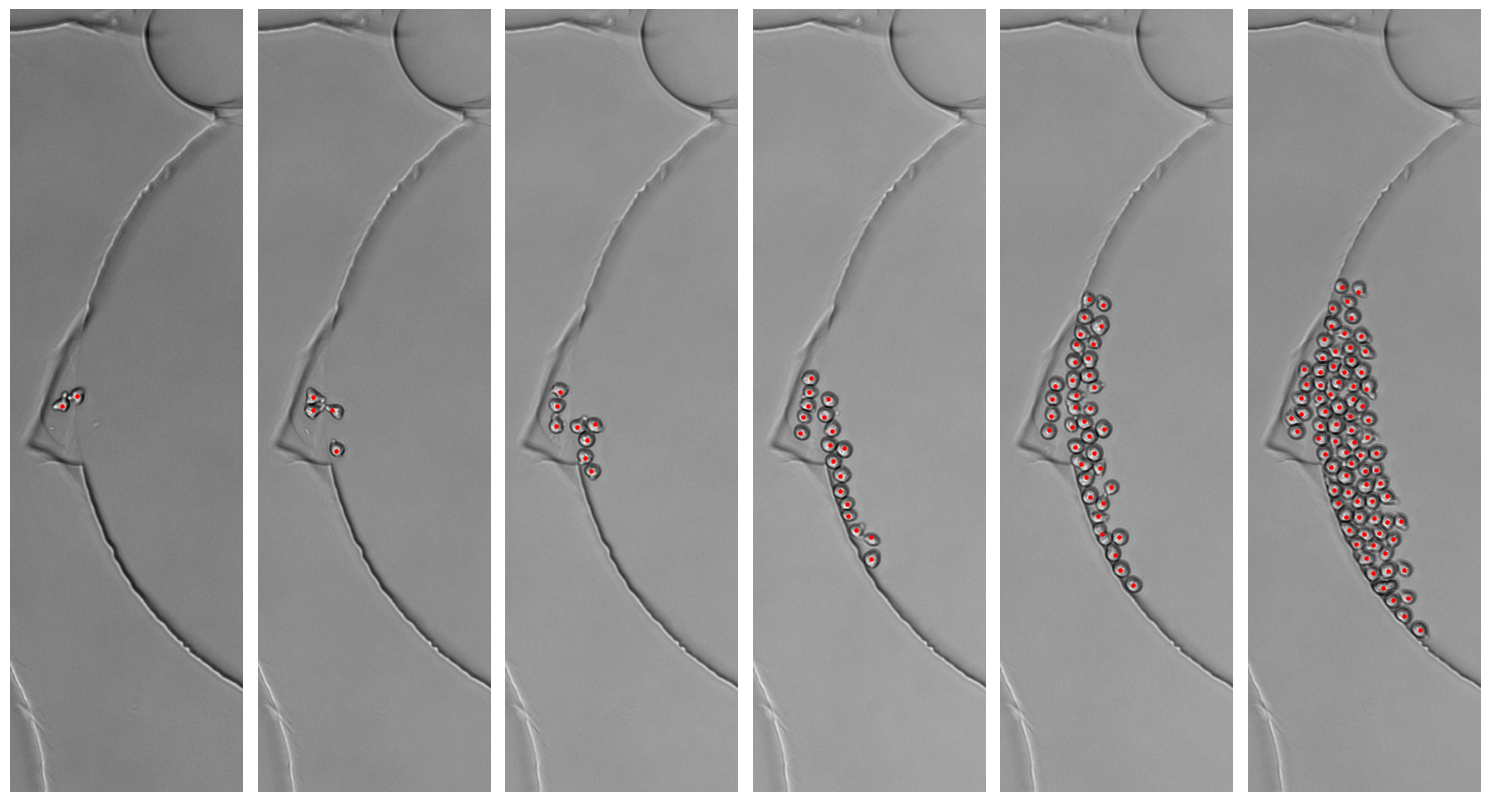

In [4]:
import matplotlib.pyplot as plt
import skimage.io

plt.figure(figsize=(15, 10))

for plt_index, data_index in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[data_index])
    
    plt.subplot(1, 6, plt_index + 1)
    plt.imshow(image, cmap="gray")
    for prop in props:
        plt.scatter(prop.centroid[1], prop.centroid[0], s=5, color="red")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Prepare the Training Crop

We will use a single crop of a single cell to train the neural network.

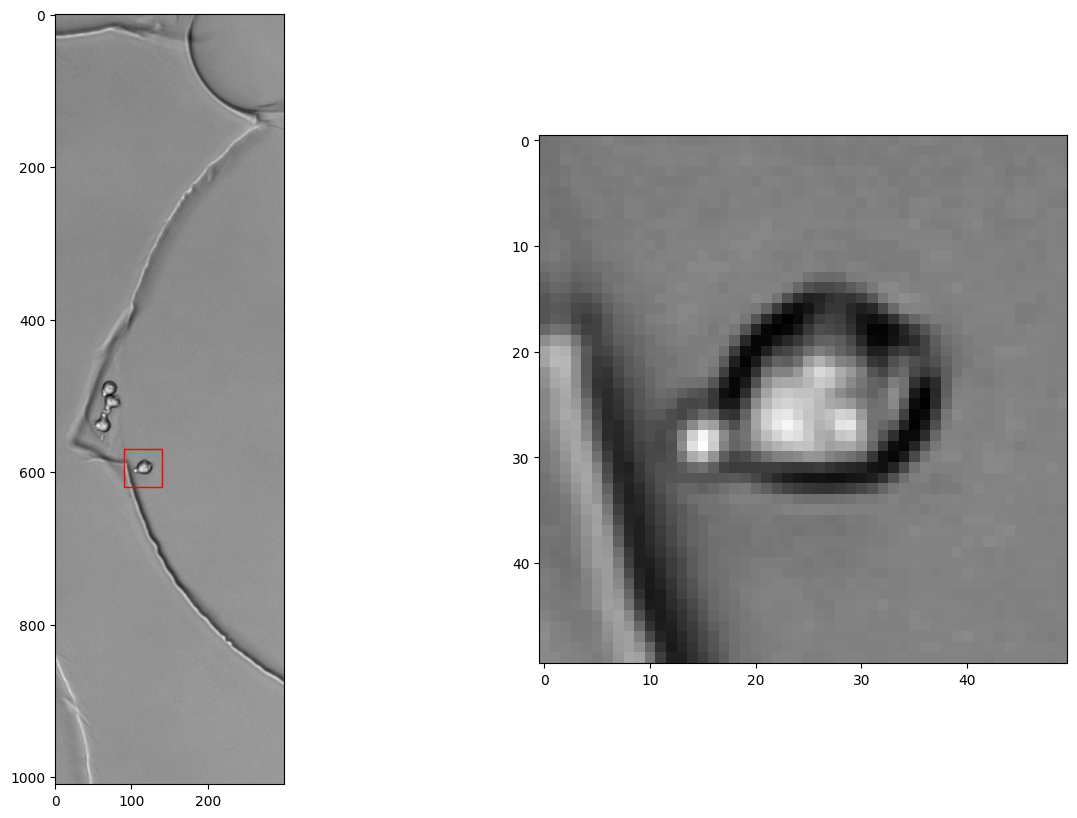

In [5]:
import matplotlib.patches as patches

crop_frame_index = 282
crop_size = 50
crop_x0, crop_y0 = 595 - crop_size // 2, 115 - crop_size // 2

image, *props = pipeline(sources[crop_frame_index])
crop = image[crop_x0:crop_x0 + crop_size, crop_y0:crop_y0 + crop_size]

plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray")
plt.gca().add_patch(patches.Rectangle((crop_y0, crop_x0), crop_size, crop_size,
                                      linewidth=1, edgecolor="r",
                                      facecolor="none"))

plt.subplot(1, 2, 2)
plt.imshow(crop, cmap="gray")

plt.show()

We use this crop to create a training pipeline ...

In [6]:
import numpy as np
import torch

training_pipeline = (
    dt.Value(crop)
    >> dt.Multiply(lambda: np.random.uniform(0.9, 1.1))
    >> dt.Add(lambda: np.random.uniform(-0.1, 0.1))
    >> dt.MoveAxis(-1, 0)
    >> dt.pytorch.ToTensor(dtype=torch.float32)
)

training_dataset = dt.pytorch.Dataset(training_pipeline, length=400, 
                                      replace=False)

In [7]:
import deeptrack.deeplay as dl 

dataloader = dl.DataLoader(training_dataset, batch_size=8, shuffle=True)

In [8]:
lodestar = dl.LodeSTAR(n_transforms=4, optimizer=dl.Adam(lr=1e-4)).build()
trainer = dl.Trainer(max_epochs=200)
trainer.fit(lodestar, dataloader)

c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
c:\Users\GU\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:454: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
INFO: 
  | Name          | Type                       | Params
-------------------------------------------------------------
0 | model         | ConvolutionalNeuralNetwork | 251 K 
1 | between_loss  | L1Loss                     | 0     
2 | within_loss   | L1Loss                     | 0     
3 | train_metrics | MetricCollection           | 0     
4 | val_metrics   | MetricCollection           | 0     
5 | test_metrics  | MetricCollection           | 0     
6 | optimizer     | Adam                       | 0     
-----------------------------

Training: |          | 0/? [00:00<?, ?it/s]

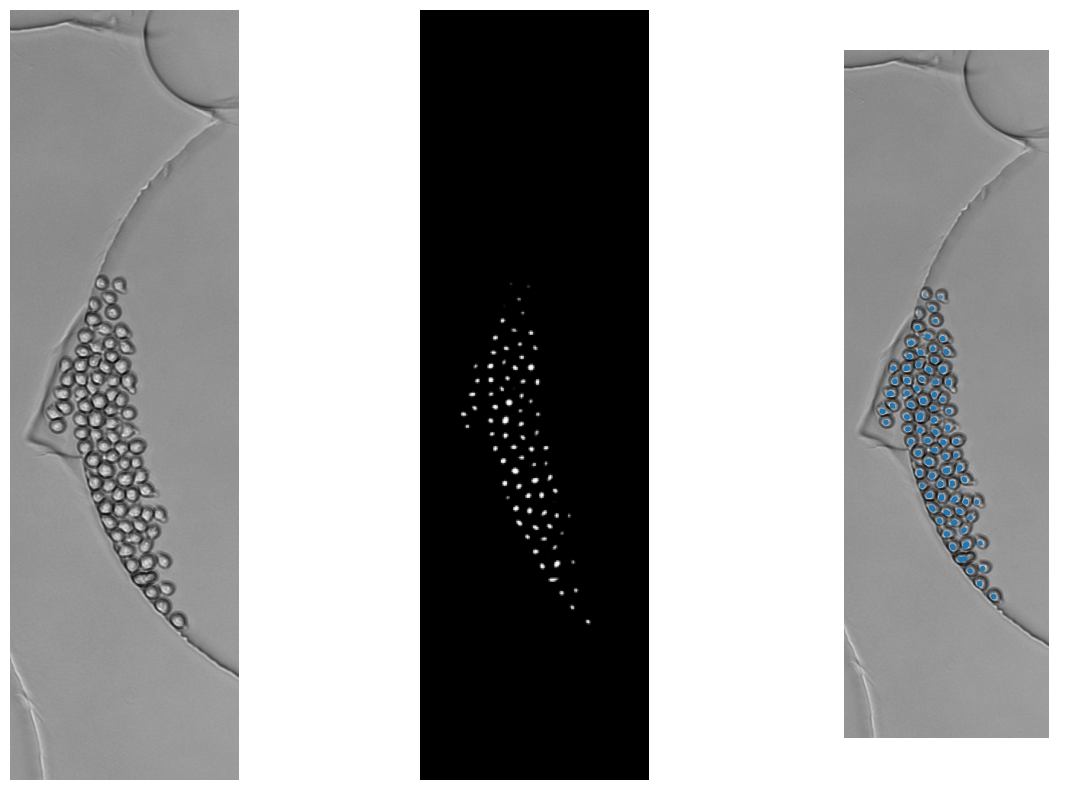

In [9]:
image_index = 1500
image, *props = pipeline(sources[image_index])
torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
prediction = lodestar(torch_image)[0].detach().numpy()
x, y, rho = prediction[0], prediction[1], prediction[-1]

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(rho, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image, cmap="gray")
plt.scatter(y.flatten(), x.flatten(), alpha=rho.flatten() / rho.max(), s=5)
plt.axis("off")

plt.show()

In [11]:
alpha = 0.2
beta = 0.8
cutoff = 0.2
mode = "constant"

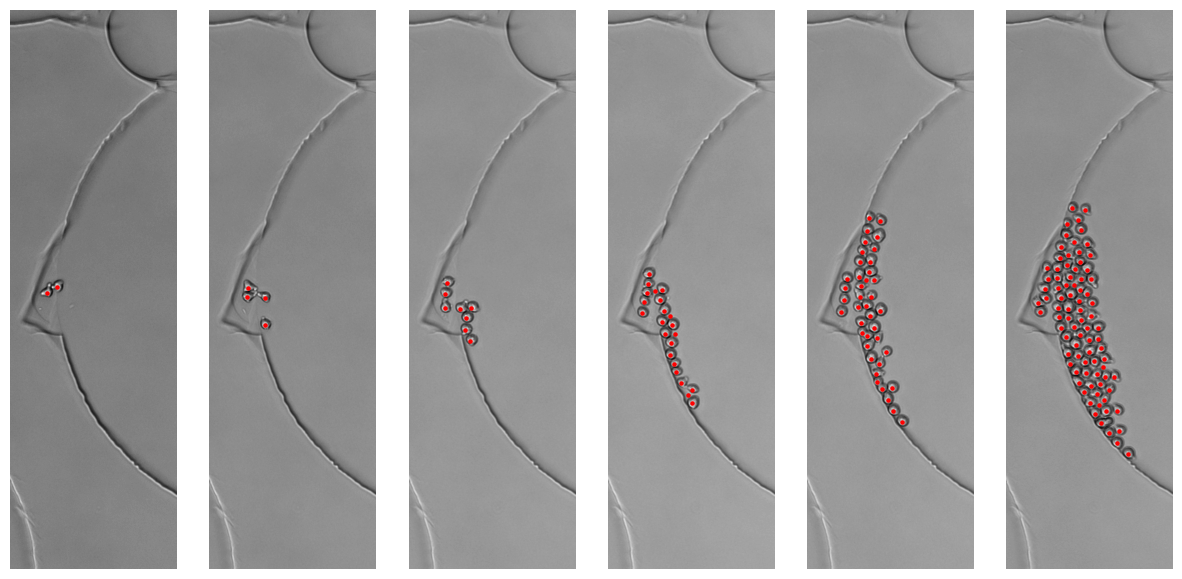

In [12]:
plt.figure(figsize=(15, 10))

for plot_idx, frame_idx in enumerate([0, 300, 600, 900, 1200, 1500]):
    image, *props = pipeline(sources[frame_idx])
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta, 
                                 mode="constant", cutoff=cutoff)[0]

    plt.subplot(1, 6, plot_idx + 1)
    plt.imshow(image, cmap="gray")
    plt.scatter(detections[:, 1], detections[:, 0], s=5, color="red")
    plt.axis("off")

plt.show()

In [13]:
import scipy
import tqdm 

distance_th = 10

TP, FP, FN = 0, 0, 0
for source in tqdm.tqdm(sources[::10]):
    image, *props = pipeline(source)
    torch_image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float()
    detections = lodestar.detect(torch_image, alpha=alpha, beta=beta,
                                 mode="constant", cutoff=cutoff)[0]
    centroids = np.array([prop.centroid[:2] for prop in props])

    distance_matrix = scipy.spatial.distance_matrix(detections, centroids)
    row_idx, col_idx = scipy.optimize.linear_sum_assignment(distance_matrix)

    filtered_row_ind = row_idx[distance_matrix[row_idx, col_idx] < distance_th]
    filtered_col_ind = col_idx[distance_matrix[row_idx, col_idx] < distance_th]

    TP += len(filtered_row_ind)
    FP += len(detections) - len(filtered_row_ind)
    FN += len(centroids) - len(filtered_col_ind)

F1 = 2 * TP / (2 * TP + FP + FN)

print(f"""
TP: {TP}
FP: {FP}
FN: {FN}
F1: {F1}  
""")

100%|██████████| 177/177 [00:43<00:00,  4.08it/s]


TP: 6466
FP: 404
FN: 9
F1: 0.9690520794304983  

